### Import numpy, PIL and some sklearn modules for the popular olivetti dataset and splitting training data.

In [111]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from helpers import negative_vector
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define constants.

In [112]:
# Define constants
IMG_SHAPE = (64, 64)
DATASET_SIZE = 400

### Download the dataset, reshape the images into vectors and split it into pieces for training.
- We fetch the olivetti dataset via sklearn
- olivetti.images is a collection of vectors, raveled 64x64 sized images
- olivetti.target contains the id's of the people in the X array in the corresponding indices
- We give the indices to the train_test_split to track which person is in which index after the function shuffles them, this will later be used to determine whether the algorithm predicted the correct person

In [113]:
def display_arr(img_vectors: np.array, n, step=10):
    arr = range(0, 100, step)
    for i in range(0, n):
        plt.subplot(2,4,1+i)
        plt.imshow(img_vectors[arr[i]].reshape(IMG_SHAPE), cmap='Greys')
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    plt.show()


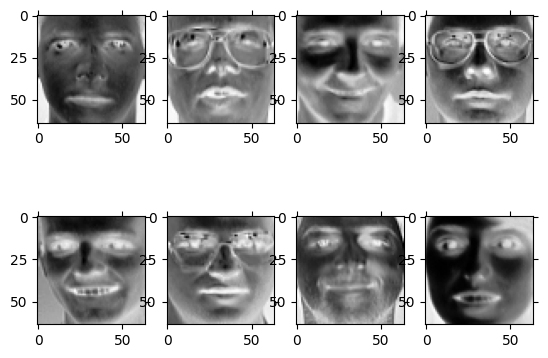

In [114]:
from matplotlib import pyplot as plt
from PIL import Image
import ipyplot
import IPython.display as dsp

# Download Olivetti faces dataset
olivetti = fetch_olivetti_faces()
X = olivetti.images[:DATASET_SIZE]
y = olivetti.target[:DATASET_SIZE]

# Print info on shapes and reshape where necessary
X = X.reshape((DATASET_SIZE, 4096))
indices = np.arange(len(X))
Xtrain, Xtest, ytrain, ytest, idx_train, idx_test = train_test_split(X, y, indices)

display_arr(X, 8)

# ipyplot.plot_images(images=[pilimg.convert('RGB')])

### Construct the average face from the training set.
- Add all training vectors together and divide the sum by the number of images.

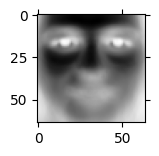

In [115]:
training_set = Xtrain
# Average face using numpy
avg_face = training_set.mean(axis=0)

display_arr([avg_face], 1)

### Derive normalized faces
- Subtract the average face from each of the faces in the training set

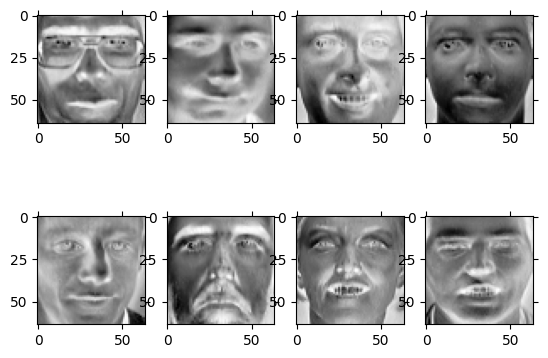

In [116]:
# Let's create the matrix A by subtracting the average face from each face in the training set
normalized_faces = []
neg_avg_face = negative_vector(avg_face)
sub = None
for v in training_set:
    sub = np.subtract(v, avg_face)
    normalized_faces.append(sub)

display_arr(normalized_faces, 8)

### Form the covariance matrix
- Transpose the matrix of normalized faces
- Multiply the normalized faces matrix with its transposition

In [117]:
# Form the covariance matrix
normalized_faces_t = np.array(normalized_faces).transpose()

cov_matrix = np.cov(np.array(normalized_faces))

### Calculate the eigenvalues and eigenvectors for the covariance matrix
- In order to determine the strongest eigenfaces, we select the eigenvectors with the highest corresponding eigenvalues
- Pair the eigenvalues/eigenvectors
- Sort the pairs based on the highest eigenvalues

In [118]:
# Calculate the eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
eig_pairs = [(eigenvalues[index], eigenvectors[:, index]) for index in range(len(eigenvalues))]

eig_pairs.sort(reverse=True)
eigvalues_sort = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

### Select the 20 best eigenvectors

In [119]:
# Choose the n eigenvectors with the highest eigenvalues as the eigenfaces
eigenfaces = np.array(eigvectors_sort[:20]).transpose()

### Create reduced eigenface space and calculate the weights for the projected vectors
- Project the eigenfaces to the training_sets transposition by performing a dot product between the two
- A weight is calculated by performing a dot product between each normalized face and the projections

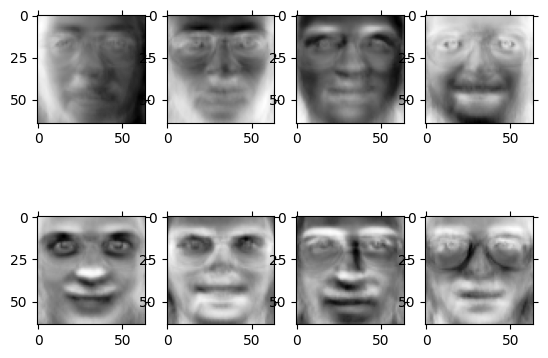

In [120]:
proj_data = np.dot(training_set.transpose(), eigenfaces)
proj_data = proj_data.transpose()

display_arr(proj_data, 8, 1)

# Calculate weights for eigenfaces
w = np.array([np.dot(proj_data, i) for i in np.array(normalized_faces)])

### Calculate distance between the weights of each eigenface and the test image
- Create the normalized unknown face
- Calculate the weights of the normalized unknown weights in respect to the projections
- Create the difference vector, which is the weights of the eigenfaces subracted from the weights of the test image
- Find the index of the lowest difference

In [121]:
%load_ext autoreload
%autoreload 2
from src.helpers import predict

correct_ids_euclidean = []
predicted_ids_euclidean = []

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
from helpers import manhattan_distance, hamming_distance, euclidean_distance

# Store the correct ids and the predicted ids in corresponding indices
correct_ids = []
for i in range(len(Xtest)):
    correct_ids.append(y[idx_test[i]])

# Make predictions with different distance measurements
predicted_ids_knn     = predict(Xtest, y, idx_train, avg_face, proj_data, w, distance_func=manhattan_distance, type="KNN", sample_size=3, threshold=2)
predicted_ids_euclidean = predict(Xtest, y, idx_train, avg_face, proj_data, w, distance_func=euclidean_distance)
predicted_ids_manhattan = predict(Xtest, y, idx_train, avg_face, proj_data, w, distance_func=manhattan_distance)
predicted_ids_hamming   = predict(Xtest, y, idx_train, avg_face, proj_data, w, distance_func=hamming_distance)

### Create classification reports

In [123]:
from sklearn.metrics import classification_report
knn = classification_report(correct_ids, predicted_ids_knn, zero_division=0, output_dict=True)
euclidean = classification_report(correct_ids, predicted_ids_euclidean, zero_division=0, output_dict=True)
manhattan = classification_report(correct_ids, predicted_ids_manhattan, zero_division=0, output_dict=True)
hamming = classification_report(correct_ids, predicted_ids_hamming, zero_division=0, output_dict=True)

### Compare performance

In [124]:
methods = {'KNN, (manhattan)': knn, 'euclidean': euclidean, 'manhattan': manhattan, 'hamming': hamming}

print(f'{"method":21}{"precision":15}{"recall":15}{"f1-score"}')
for key in methods:
    precision = methods[key]['weighted avg']['precision'].__str__()[:4]
    recall = methods[key]['weighted avg']['recall'].__str__()[:4]
    f1 = methods[key]['weighted avg']['f1-score'].__str__()[:4]
    print(f"{key + ':':20} {precision:15}{recall:15}{f1}")

method               precision      recall         f1-score
KNN, (manhattan):    0.73           0.69           0.68
euclidean:           0.90           0.84           0.84
manhattan:           0.90           0.85           0.84
hamming:             0.00           0.03           0.00
